# MLP regression using ACSF (atom-centered symmetry functions) descriptors

## Setting up the notebook and importing necessary dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import requests
from io import StringIO
warnings.filterwarnings('ignore')

!pip install rdkit
!pip install dscribe

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from rdkit.Chem import Descriptors
from dscribe.descriptors import ACSF
from ase import Atoms
from rdkit.Chem.rdmolfiles import MolToXYZBlock

## Loading the ESol dataset and observing its properties

In [5]:
def load_esol_dataset():
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"  # URL of the dataset
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")

    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()

Loaded ESOL with 1128 compounds


Dataset shape: (1128, 3)
LogS range: -11.60 to 1.58
LogP range: -7.57 to 10.39

Sample data:
                                              SMILES  LogS     LogP
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77 -3.10802
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30  2.84032
2                               CC(C)=CCCC(C)=CC(=O) -2.06  2.87800
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87  6.29940
4                                            c1ccsc1 -1.33  1.74810


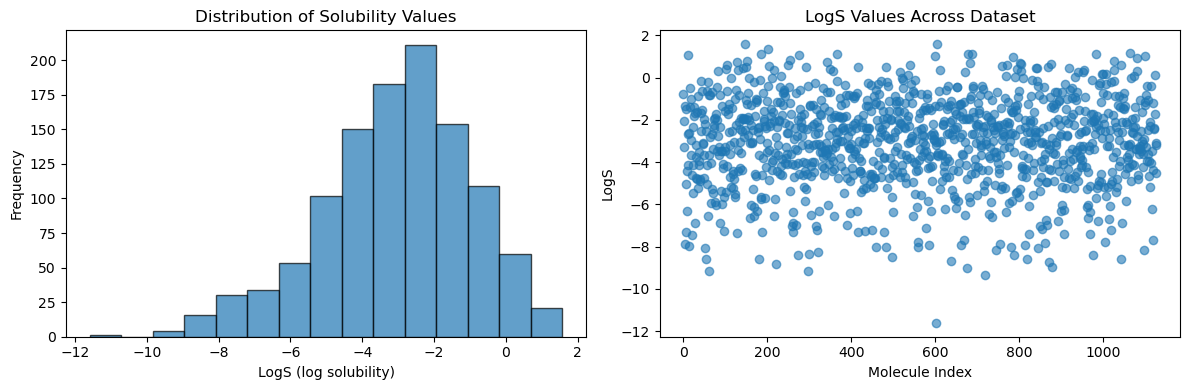

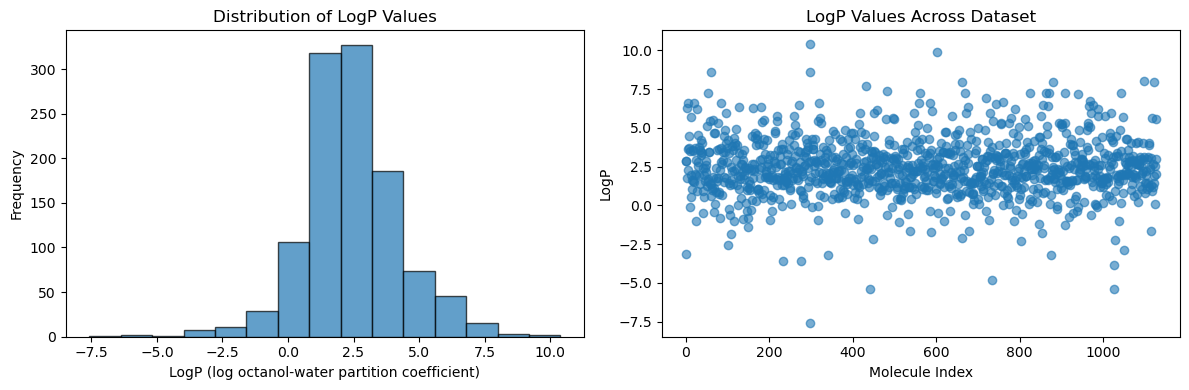

In [6]:
logp_values = []  # Initialize a list to store LogP values
for smile in df['SMILES']:  # Iterate through each SMILES string in the dataset
    mol = Chem.MolFromSmiles(smile)  # Convert SMILES to RDKit molecule
    if mol:  # Check if the molecule is valid
        logp = Descriptors.MolLogP(mol)  # Calculate the LogP value using RDKit
        logp_values.append(logp)  # Append the LogP value to the list
    else:
        logp_values.append(np.nan)  # Append NaN for invalid molecules

df['LogP'] = list(np.array(logp_values))  # Add the LogP values as a new column in the DataFrame
print(f"Dataset shape: {df.shape}")  # Print the shape of the dataset
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")  # Print the range of LogS values
print(f"LogP range: {df['LogP'].min():.2f} to {df['LogP'].max():.2f}")  # Print the range of LogP values
print("\nSample data:")  # Print a message indicating sample data
print(df.head())  # Display the first few rows of the dataset

# Visualize distribution
plt.figure(figsize=(12, 4))  # Create a figure with a specific size

# Plot histogram of LogS values
plt.subplot(1, 2, 1)  # Create the first subplot
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')  # Plot a histogram of LogS values
plt.xlabel('LogS (log solubility)')  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis
plt.title('Distribution of Solubility Values')  # Add a title to the plot

# Plot scatter plot of LogS values
plt.subplot(1, 2, 2)  # Create the second subplot
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)  # Plot LogS values against molecule indices
plt.xlabel('Molecule Index')  # Label the x-axis
plt.ylabel('LogS')  # Label the y-axis
plt.title('LogS Values Across Dataset')  # Add a title to the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

# Visualize LogP
plt.figure(figsize=(12, 4))  # Create another figure with a specific size

# Plot histogram of LogP values
plt.subplot(1, 2, 1)  # Create the first subplot
plt.hist(df['LogP'], bins=15, alpha=0.7, edgecolor='black')  # Plot a histogram of LogP values
plt.xlabel('LogP (log octanol-water partition coefficient)')  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis
plt.title('Distribution of LogP Values')  # Add a title to the plot

# Plot scatter plot of LogP values
plt.subplot(1, 2, 2)  # Create the second subplot
plt.scatter(range(len(df)), df['LogP'], alpha=0.6)  # Plot LogP values against molecule indices
plt.xlabel('Molecule Index')  # Label the x-axis
plt.ylabel('LogP')  # Label the y-axis
plt.title('LogP Values Across Dataset')  # Add a title to the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots


## 3D Molecular Representation

This function takes a SMILES (Simplified Molecular Input Line Entry System) string as input,
generates a 3D molecular structure, and optimizes its geometry using the Universal Force Field (UFF).
If the generation or optimization fails, it retries up to a specified number of attempts.

In [8]:
def generate_3d_conformation(smiles, max_attempts=10):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Add hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    for attempt in range(max_attempts):
        try:
            # Embed molecule in 3D
            result = rdDistGeom.EmbedMolecule(mol, randomSeed=42+attempt)
            if result == -1:
                continue

            # Optimize geometry with UFF
            UFFOptimizeMolecule(mol)
            return mol

        except Exception as e:
            continue

    return None

In [9]:
atom_set = set()

for smiles in df['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom_set.add(atom.GetSymbol())

print("Atoms in ESOL dataset:", sorted(atom_set))

Atoms in ESOL dataset: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']


## Symmetry Function

The symmetry function which we are using is ACSF descriptors. ACSF descriptors are powerful mathematical descriptors in computational chemistry, used to create numerical "fingerprints" of an atom's local environment by describing the distribution of neighboring atoms in terms of radial distances and angular arrangements. They use Gaussian functions to build a unique signature for each atom, allowing AI models to learn chemical behaviors from structure. 

In [10]:
def generate_acsf(smiles, acsf_params):

    mol = generate_3d_conformation(smiles)  # Generate a 3D molecular conformation from the SMILES string.
    if mol is None:  # Check if the 3D conformation generation failed.
        print(f"Failed to generate 3D structure for: {smiles}")  # Print an error message for failed generation.
        return None  # Return None if the 3D structure generation fails.

    # Convert RDKit molecule to ASE Atoms object
    xyz_block = MolToXYZBlock(mol)  # Convert the RDKit molecule to an XYZ block format.
    atoms = Atoms(  # Create an ASE Atoms object from the XYZ block.
        symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],  # Extract atomic symbols from the molecule.
        positions=[list(map(float, line.split()[1:4])) for line in xyz_block.splitlines()[2:]]  # Extract atomic positions.
    )

    # Initialize ACSF descriptor
    acsf = ACSF(**acsf_params)  # Create an ACSF descriptor object with the specified parameters.

    # Generate ACSF descriptors (n_atoms x n_features)
    acsf_descriptors = acsf.create(atoms)  # Generate ACSF descriptors for the molecule.
    return acsf_descriptors  # Return the ACSF descriptors.

def create(df):
    # Dynamically determine elements in the dataset
    acsf_params = {  # Define ACSF parameters for descriptor generation.
        "species": ["H", "C", "O", "N", "F", "Cl", "Br", "S", "P", "I"],  # List of atomic species to consider.
        "r_cut": 6.0,  # Cutoff radius for ACSF calculations.
        "g2_params": [[1, 1], [1, 2], [1, 3]],  # Parameters for G2 symmetry functions.
        "g4_params": [[1, 1, 1], [1, 1, 2], [1, 1, 3]],  # Parameters for G4 symmetry functions.
    }

    acsf_d = []  # Initialize a list to store ACSF descriptors for all molecules.
    max_atoms = 0  # Variable to track the maximum number of atoms in any molecule.
    n_features = None  # Variable to store the number of features in the ACSF descriptors.

    for smiles in df['SMILES']:  # Iterate through each SMILES string in the dataset.
        acsf_desc = generate_acsf(smiles, acsf_params)  # Generate ACSF descriptors for the molecule.
        if acsf_desc is not None:  # Check if descriptor generation was successful.
            if n_features is None:  # If the number of features is not yet determined.
                n_features = acsf_desc.shape[1]  # Set the number of features based on the first valid descriptor.
            max_atoms = max(max_atoms, acsf_desc.shape[0])  # Update the maximum number of atoms if necessary.
            acsf_d.append(acsf_desc)  # Append the descriptor to the list.
        else:
            acsf_d.append(None)  # Append None for molecules where descriptor generation failed.

    # Pad all descriptors to (max_atoms, n_features)
    processed = []  # Initialize a list to store processed (padded) descriptors.
    for desc in acsf_d:  # Iterate through the list of descriptors.
        if desc is None:  # If the descriptor is None (failed generation).
            padded = np.zeros((max_atoms, n_features))  # Create a zero-padded array.
        else:
            pad_rows = max_atoms - desc.shape[0]  # Calculate the number of rows to pad.
            padded = np.vstack([desc, np.zeros((pad_rows, n_features))])  # Pad the descriptor with zeros.
        processed.append(padded.flatten())  # Flatten the padded descriptor and append to the list.

    return np.array(processed)  # Convert the list of processed descriptors to a numpy array and return it.

In [11]:
# Generate ACSF descriptors
X = create(df)  # Generate ACSF descriptors for all molecules in the dataset `df`.

y = df[['LogS', 'LogP']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  


## Defining the Pytorch `Dataset` and `Dataloader`

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Define a custom PyTorch Dataset class for the ESOL dataset
class ESOLDataset(Dataset):
    def __init__(self, X, y):
        # Initialize the dataset with features (X) and targets (y)
        self.X = X
        self.y = y

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # Retrieve a single sample (features and target) by index
        return self.X[idx], self.y[idx]

train_dataset = ESOLDataset(X_train_tensor, y_train_tensor)
val_dataset = ESOLDataset(X_val_tensor, y_val_tensor)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Model Architecture

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, h1_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(h2_size, output_size)
        )
    def forward(self, x):
        return self.model(x)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

model = MLP(input_size=24395, h1_size=32, h2_size=64, output_size=2).to(device)  

### Defining the optimizer and loss criterion

In [15]:
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

## Training the model

Epoch 1/50 | Train Loss: 10.8156 | Val Loss: 9.5820
Epoch 2/50 | Train Loss: 8.4327 | Val Loss: 6.9539
Epoch 3/50 | Train Loss: 5.7162 | Val Loss: 4.9515
Epoch 4/50 | Train Loss: 3.4226 | Val Loss: 3.9988
Epoch 5/50 | Train Loss: 2.8533 | Val Loss: 3.6031
Epoch 6/50 | Train Loss: 2.5088 | Val Loss: 3.4027
Epoch 7/50 | Train Loss: 2.4022 | Val Loss: 3.2282
Epoch 8/50 | Train Loss: 2.1703 | Val Loss: 3.1252
Epoch 9/50 | Train Loss: 1.9197 | Val Loss: 3.0584
Epoch 10/50 | Train Loss: 1.8172 | Val Loss: 2.9174
Epoch 11/50 | Train Loss: 1.6460 | Val Loss: 2.8740
Epoch 12/50 | Train Loss: 1.6044 | Val Loss: 2.8385
Epoch 13/50 | Train Loss: 1.6101 | Val Loss: 2.7781
Epoch 14/50 | Train Loss: 1.4845 | Val Loss: 2.6961
Epoch 15/50 | Train Loss: 1.5232 | Val Loss: 2.7080
Epoch 16/50 | Train Loss: 1.3726 | Val Loss: 2.6672
Epoch 17/50 | Train Loss: 1.2319 | Val Loss: 2.6827
Epoch 18/50 | Train Loss: 1.2700 | Val Loss: 2.6579
Epoch 19/50 | Train Loss: 1.2124 | Val Loss: 2.7005
Epoch 20/50 | Train 

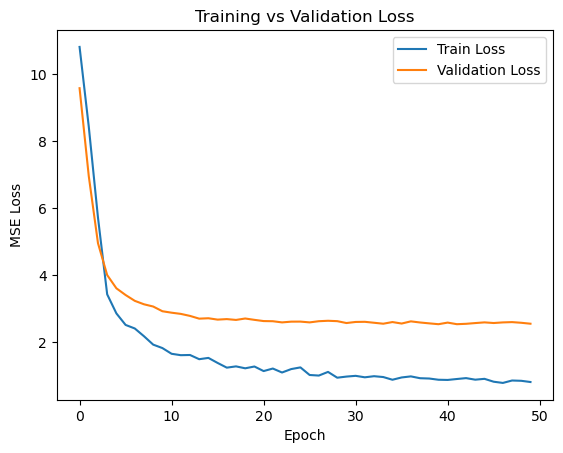

In [16]:
train_losses = []
val_losses = []

epochs = 50 
for epoch in range(epochs): 
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item()
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/50 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Plot the training and validation loss curves.
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss') 
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

## Evaluate the model

In [17]:
def evaluate_model(model, dataloader):

    model.eval()
    all_targets = [] 
    all_predictions = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_targets.extend(yb.cpu().numpy()) 
            all_predictions.extend(preds.cpu().numpy())

    all_targets = np.array(all_targets).flatten()
    all_predictions = np.array(all_predictions).flatten()

    mse = mean_squared_error(all_targets, all_predictions)  # Compute the Mean Squared Error (MSE).
    r2 = r2_score(all_targets, all_predictions)  # Compute the R-squared (R2) score.
    mae = mean_absolute_error(all_targets, all_predictions)  # Compute the Mean Absolute Error (MAE).

    return mse, r2, mae  # Return the computed metrics.

# Evaluate the model on the validation dataset and compute metrics.
mse, r2, mae = evaluate_model(model, val_loader)
print(f"Test MSE: {mse:.4f}")  
print(f"Test R2: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")

Test MSE: 2.8630
Test R2: 0.7583
Test MAE: 0.9289
